In [2]:
#2020/2/17 杨树澄
#读取routing程序生成的信息
#bBox的坐标为 1->左下x 2->左下y 3->右上x 4->右上y 
#update:bBox好像没啥用了 可以直接用origin和area两个参数来界定 效果更精确一些 后期网表变大后考虑去掉bBox相关

In [1]:
from pylab import *
from SFQ_lib import *
import sys
import re

In [2]:
def floor_to_decimal(num): #把bBox误差出来的小数都去掉
    index=30
    return int(round(num/index))*index

In [3]:
def read_layout(filename): #io接口，用来读取SKILL输出的版图信息
    instance_info=[]#module名
    orient_info=[]#方向
    inst_name_info=[]#例化名
    with open(filename[0]) as f:
        for line in f.readlines():
            line=line.rstrip('\n')
            instance_info.append(line.rstrip('\n'))  
    with open(filename[1]) as f:
        for line in f.readlines():
            line=line.rstrip('\n')
            orient_info.append(line.rstrip('\n'))
    length=len(instance_info)
    bBox_info_pre=[]
    with open(filename[2]) as f:
        for line in f.readlines():
            line=line.rstrip('\n')
            bBox_info_pre.append(line.rstrip('\n')) 
    bBox_info=[[] for i in range(int(length))]
    for i in range(0,length):
        bBox_info_pre[i]=bBox_info_pre[i].replace("(","")
        bBox_info_pre[i]=bBox_info_pre[i].replace(")","")
        bBox_info[i]=bBox_info_pre[i].split(" ")
        for k in range(0,4):
            bBox_info[i][k]=floor_to_decimal(float(bBox_info[i][k]))
    xy_info=[[] for i in range(int(length))]
    xy_info_pre=[]
    with open(filename[3]) as f:
        for line in f.readlines():
            line=line.rstrip('\n')
            xy_info_pre.append(line.rstrip('\n')) 
    for i in range(0,length):
        xy_info_pre[i]=xy_info_pre[i].replace("(","")
        xy_info_pre[i]=xy_info_pre[i].replace(")","")
        xy_info[i]=xy_info_pre[i].split(" ")
        for k in range(0,2):
            xy_info[i][k]=floor_to_decimal(float(xy_info[i][k]))
    with open(filename[4]) as f:
        for line in f.readlines():
            line=line.rstrip('\n')
            inst_name_info.append(line.rstrip('\n'))              
    return [instance_info, orient_info, bBox_info,xy_info,inst_name_info]

In [4]:
def layout_info_summary(filename):#数据顺序：model，方向，bBox，起始点,汇总到一个info变量里
    basic_info=read_layout(filename)
    len_layout_inst=len(basic_info[0])
    layout_info_out=[[] for i in range(int(len_layout_inst))]
    for i in range(0,len_layout_inst):
        layout_info_out[i]=layout_to_model(basic_info[0][i],basic_info[4][i])
        layout_info_out[i].orient=basic_info[1][i]
        layout_info_out[i].xy=basic_info[3][i]
        #layout_info_out[i].append(basic_info[3][i])
    return layout_info_out

In [5]:
#测试模块
file_list=["routing_name.txt","routing_orient.txt","routing_bbox.txt", "routing_xy.txt","routing_inst.txt"]
layout_info=layout_info_summary(file_list)
print(layout_info)
print(layout_info[0].xy)

[<SFQ_lib.and_e object at 0x000001D01F6D3710>, <SFQ_lib.d22_a object at 0x000001D01F6D3D68>, <SFQ_lib.cb_a object at 0x000001D01F6D3EF0>]
[-90, 0]


In [6]:
connection=['I3,wireAI,I2,wireTO', 'I3,wireBI,I1,wireABO']
list_layout_info=read_layout(file_list)
def connect_info_process(connection):
    len_connect=len(connection)
    connection_info=[]
    for i in range(0,len_connect):
        connection_info.append(connection[i].split(","))
    return connection_info
connection_info=connect_info_process(connection)

def port_rearrangement(SFQmodel):
    model_dir=dir(SFQmodel)
    len_dir=len(model_dir)
    seq_port=port_sequence()
    len_seq=len(seq_port)
    wire_name=[]
    for i in range(0,len_seq):
        if "wire"+seq_port[i] in model_dir:
            wire_name.append("wire"+seq_port[i])
    return wire_name

#print(list_layout_info)
def layout_to_dict(layout_info):
    len_layout_info=len(layout_info)
    dict_inst_to_wire={}
    for i in range(0,len_layout_info):
        inst_name=layout_info[i].instname
        wire_name=port_rearrangement(layout_info[i])
        #print(inst_name)
        #print(wire_name)
        len_wire_name=len(wire_name)
        info={}
        for j in range(0,len_wire_name):
            info_temp={wire_name[j]:layout_info[i].port_type[j],"area":layout_info[i].area,"orient":layout_info[i].orient,"origin":layout_info[i].xy}
            #print(info_temp)
            info.update(info_temp)
        dict_temp={layout_info[i].instname:info}
        #print(info)
        #print(dict_temp)
        dict_inst_to_wire.update(dict_temp)
    return dict_inst_to_wire
dictionary=layout_to_dict(layout_info)
print(dictionary)
#print(layout_info[0].area)

{'I1': {'wireAI': 1, 'area': [3, 3], 'orient': 'MYR90', 'origin': [-90, 0], 'wireTI': 2, 'wireBI': 3, 'wireABO': 8}, 'I2': {'wireAI': 1, 'area': [2, 2], 'orient': 'R0', 'origin': [-60, 120], 'wireTI': 3, 'wireTO': 5}, 'I3': {'wireAI': 1, 'area': [2, 2], 'orient': 'R0', 'origin': [270, 90], 'wireBI': 2, 'wireABO': 5}}


In [7]:
def get_route_coord(connection_info,dict_inst_to_wire):#获取port到port的绝对坐标
    len_connection=len(connection_info)
    routing_coord=[]
    for i in range(0,len_connection):
        print(connection_info[i][0])
        dict_of_first_inst=dict_inst_to_wire[connection_info[i][0]]
        dict_of_second_inst=dict_inst_to_wire[connection_info[i][2]]
        start_wire=connection_info[i][1]
        end_wire=connection_info[i][3]
        start_port=dict_of_first_inst[start_wire]
        end_port=dict_of_second_inst[end_wire]
        first_inst_area=dict_of_first_inst["area"]
        second_inst_area=dict_of_second_inst["area"]        
        start_relative_coord=port_location(start_port,first_inst_area)[0]
        start_index=port_location(start_port,first_inst_area)[1]
        end_relative_coord=port_location(end_port,second_inst_area)[0]
        end_index=port_location(end_port,second_inst_area)[1]
        first_inst_orient=dict_of_first_inst["orient"]
        second_inst_orient=dict_of_second_inst["orient"] 
        first_inst_origin=dict_of_first_inst["origin"]
        second_inst_origin=dict_of_second_inst["origin"]
        first_abs_coord=get_abs_coord(first_inst_orient,first_inst_origin,start_relative_coord,start_index)
        second_abs_coord=get_abs_coord(second_inst_orient,second_inst_origin,end_relative_coord,end_index)
        routing_coord.append([first_abs_coord,second_abs_coord])
    return routing_coord
coord_info=get_route_coord(connection_info,dictionary)
print(coord_info)

I3
I3
[[[[270, 135], 1], [[0, 135], 3]], [[[270, 105], 1], [[-135, -90], 2]]]


In [8]:
def to_dbCreate(model,instname,coord,orient):
    '''cellID=dbOpenCellViewByType("ysc_layout" "layouttest" "layout" "maskLayout" "w")
    dbCreateParamInstByMasterName(cellID
    "ysc03_lib" "jtl_crs22_2x2_bi1ai2bo3ao5" "layout" "inst1" list(120 120) "R0")
    jtl1j_a_1x1ai1ao3
    '''
    dbcreate= "dbCreateParamInstByMasterName(cellID \"ysc03_lib\" \"{0}\" \"layout\" \"{1}\" list({2} {3}) \"{4}\")".format(model,instname,coord[0],coord[1],orient)
    #print(dbcreate)
    return dbcreate

In [9]:
def direction_to_inst(input_direction,output_direction):
    if(input_direction==1):
        if(output_direction==1):
            model="jtl1j_a_1x1ai1ao3"
            orient="MY"
            origin=[-1,0]
        elif(output_direction==2):
            model="jtl1j_a_1x1ai1ao4"
            orient="R180"
            origin=[-1,1]
        elif(output_direction==4):
            model="jtl1j_a_1x1ai1ao4"
            orient="MY"
            origin=[1,0]
        else:
            raise Error("Wrong routing strategy: undefined direction -2")
    elif(input_direction==2):
        if(output_direction==1):
            model="jtl1j_a_1x1ai1ao4"
            orient="MYR90"
            origin=[1,1]
        elif(output_direction==2):
            model="jtl1j_a_1x1ai1ao3"
            orient="R270"
            origin=[0,1]
        elif(output_direction==3):
            model="jtl1j_a_1x1ai1ao4"
            orient="R270"
            origin=[0,1]
        else:
            raise Error("Wrong routing strategy: undefined direction -2")
    elif(input_direction==3):
        if(output_direction==2):
            model="jtl1j_a_1x1ai1ao4"
            orient="MX"
            origin=[0,1]
        elif(output_direction==3):
            model="jtl1j_a_1x1ai1ao3"
            orient="R0"
            origin=[0,0]
        elif(output_direction==4):
            model="jtl1j_a_1x1ai1ao4"
            orient="R0"
            origin=[0,0]
        else:
            raise Error("Wrong routing strategy: undefined direction -2")
    elif(input_direction==4):
        if(output_direction==1):
            model="jtl1j_a_1x1ai1ao4"
            orient="R90"
            origin=[1,0]
        elif(output_direction==3):
            model="jtl1j_a_1x1ai1ao4"
            orient="MXR90"
            origin=[0,0]
        elif(output_direction==4):
            model="jtl1j_a_1x1ai1ao3"
            orient="R90"
            origin=[1,0]
        else:
            raise Error("Wrong routing strategy: undefined direction -2")
    else:
        raise Error("Wrong routing strategy: undefined direction -3")
    return [model,orient,origin]

In [10]:
def last_check_index(index):
    if(index==1):
        last_index=3
    elif(index==2):
        last_index=4;
    elif(index==3):
        last_index=1;
    elif(index==4):
        last_index=2;
    return last_index

In [11]:
#path=[[3, 2], [4, 2], [5, 2], [6, 2], [6, 3]]
def route_direction(first_location,second_location):
    #按照“十”来看，跟inst_index相同的顺序排1234
    x_delta=second_location[0]-first_location[0]
    y_delta=second_location[1]-first_location[1]
    if(x_delta==1 and y_delta==0):
        fir_to_sec=3
    elif(x_delta==-1 and y_delta==0):
        fir_to_sec=1
    elif(x_delta==0 and y_delta==1):
        fir_to_sec=4
    elif(x_delta==0 and y_delta==-1):
        fir_to_sec=2
    else:
        raise Error("Wrong routing strategy: undefined direction -1")
    return fir_to_sec

In [14]:
path=[[-5, -4], [-4, -4], [-3, -4], [-2, -4], [-1, -4], [0, -4], [1, -4], [2, -4], [3, -4], [4, -4], [5, -4], [6, -4], [7, -4], [8, -4], [8, -3], [8, -2], [8, -1], [8, 0], [8, 1], [8, 2], [8, 3]]
name="inst1_to_inst2"
index=0
def path_to_inst(path,coord_info,index,name):
    print(path)
    print(coord_info)
    len_path=len(path)
    print("cellID=dbOpenCellViewByType(\"ysc_layout\" \"auto_route\" \"layout\" \"maskLayout\" \"w+\")")
    #端口to第一个jtl
    #print(path[0])
    #print(path[1])
    first_check=route_direction(path[0],path[1])
    check_list=[first_check]
    #print(first_check)
    #print(coord_info[1][1])
    inst_to_first=direction_to_inst(coord_info[1][1],first_check)
    print(inst_to_first)
    xy_1=[(path[0][0]+inst_to_first[2][0])*30,(path[0][1]+inst_to_first[2][1])*30]
    print(xy_1)
    first_one=to_dbCreate(inst_to_first[0],"{0}_{1}".format(name,index),xy_1,inst_to_first[1])
    print(first_one)
    for i in range(1,len_path-1):
        #print(path[i])
        check_index=route_direction(path[i],path[i+1])
        #print(check_index)
        check_list.append(check_index)
        inst_to_line=direction_to_inst(check_list[i-1],check_index)
        #print(inst_to_line)
        xy_seq=[(path[i][0]+inst_to_line[2][0])*30,(path[i][1]+inst_to_line[2][1])*30]
        #print(xy_seq)
        create_inst=to_dbCreate(inst_to_line[0],"{0}_{1}".format(name,index+i),xy_seq,inst_to_line[1])
        print(create_inst)
    len_check=len(check_list)
    last_check=check_list[len_check-1]
    #print(check_list)
    #print(first_check)
    inst_to_last=direction_to_inst(last_check,last_check_index(coord_info[0][1]))
    #print(inst_to_first)
    xy_end=[(path[len_path-1][0]+inst_to_last[2][0])*30,(path[len_path-1][1]+inst_to_last[2][1])*30]
    last_one=to_dbCreate(inst_to_last[0],"{0}_{1}".format(name,index+len_path-1),xy_end,inst_to_last[1])   
    print(last_one)
path_to_inst(path,coord_info[1],index,name)

[[-5, -4], [-4, -4], [-3, -4], [-2, -4], [-1, -4], [0, -4], [1, -4], [2, -4], [3, -4], [4, -4], [5, -4], [6, -4], [7, -4], [8, -4], [8, -3], [8, -2], [8, -1], [8, 0], [8, 1], [8, 2], [8, 3]]
[[[270, 105], 1], [[-135, -90], 2]]
cellID=dbOpenCellViewByType("ysc_layout" "auto_route" "layout" "maskLayout" "w+")
['jtl1j_a_1x1ai1ao4', 'R270', [0, 1]]
[-150, -90]
dbCreateParamInstByMasterName(cellID "ysc03_lib" "jtl1j_a_1x1ai1ao4" "layout" "inst1_to_inst2_0" list(-150 -90) "R270")
dbCreateParamInstByMasterName(cellID "ysc03_lib" "jtl1j_a_1x1ai1ao3" "layout" "inst1_to_inst2_1" list(-120 -120) "R0")
dbCreateParamInstByMasterName(cellID "ysc03_lib" "jtl1j_a_1x1ai1ao3" "layout" "inst1_to_inst2_2" list(-90 -120) "R0")
dbCreateParamInstByMasterName(cellID "ysc03_lib" "jtl1j_a_1x1ai1ao3" "layout" "inst1_to_inst2_3" list(-60 -120) "R0")
dbCreateParamInstByMasterName(cellID "ysc03_lib" "jtl1j_a_1x1ai1ao3" "layout" "inst1_to_inst2_4" list(-30 -120) "R0")
dbCreateParamInstByMasterName(cellID "ysc03_lib"

In [15]:
def origin_to_blockpoint(area,origin,orient):#根据每个SFQmodel的面积，原点，方向，生成一系列在map上的block点（line不能穿过的地方）
    if(orient=="R0"):
        rel_block_point=[]
        for i in range(0,area[0]):
            for j in range(0,area[1]):
                rel_block_point.append([int(origin[0]/30+i),int(origin[1]/30+j)])
    elif(orient=="R90"):
        rel_block_point=[]
        for i in range(0,area[0]):
            for j in range(0,area[1]):
                rel_block_point.append([int((origin[0]-30)/30-j),int(origin[1]/30+i)])
    elif(orient=="R180"):
        rel_block_point=[]
        for i in range(0,area[0]):
            for j in range(0,area[1]):
                rel_block_point.append([int((origin[0]-30)/30-i),int((origin[1]-30)/30-j)])
    elif(orient=="R270"):
        rel_block_point=[]
        for i in range(0,area[0]):
            for j in range(0,area[1]):
                rel_block_point.append([int(origin[0]/30+j),int((origin[1]-30)/30-i)])
    elif(orient=="MX"):
        rel_block_point=[]
        for i in range(0,area[0]):
            for j in range(0,area[1]):
                rel_block_point.append([int(origin[0]/30+i),int((origin[1]-30)/30-j)])
    elif(orient=="MXR90"):
        rel_block_point=[]
        for i in range(0,area[0]):
            for j in range(0,area[1]):
                rel_block_point.append([int(origin[0]/30+j),int(origin[1]/30+i)])
    elif(orient=="MY"):
        rel_block_point=[]
        for i in range(0,area[0]):
            for j in range(0,area[1]):
                rel_block_point.append([int((origin[0]-30)/30-i),int(origin[1]/30+j)])
    elif(orient=="MYR90"):
        rel_block_point=[]
        for i in range(0,area[0]):
            for j in range(0,area[1]):
                rel_block_point.append([int((origin[0]-30)/30-j),int((origin[1]-30)/30-i)])
    return rel_block_point
test=origin_to_blockpoint([3,2],[270,150],"MYR90")
print(test)

[[9, 5], [8, 5], [9, 4], [8, 4], [9, 3], [8, 3]]


In [19]:
def get_abs_block_point(layout_origin,block_point):
    len_block_point=len(block_point)
    abs_point=[]
    for i in range(0,len_block_point):
        #print(block_point[i])
        abs_point_temp=[block_point[i][0]-layout_origin[0],block_point[i][1]-layout_origin[1]]
        abs_point.append(abs_point_temp)
    #print(abs_point)
    return abs_point
get_abs_block_point([-2,3],test)

[[11, 2], [10, 2], [11, 1], [10, 1], [11, 0], [10, 0]]


In [18]:
#有了A*了好像不太需要这种
def create_inst(coord_info):
    len_coord_info=len(coord_info)
    for i in range(0,len_coord_info):
        #print(coord_info[i][0])
        #print(coord_info[i][1][0])
        start_index=coord_info[i][0][1]
        end_index=coord_info[i][1][1]
        print(start_index)
        print(end_index)
        x_length=abs(coord_info[i][0][0][0]-coord_info[i][1][0][0])
        y_length=abs(coord_info[i][0][0][1]-coord_info[i][1][0][1])
        #print(x_length)
        #print(y_length)
        x_num=int(x_length/30)
        y_num=int(y_length/30)
        #print(x_num)
        #print(y_num)
        abs_x_coord=[]
        abs_y_coord=[]
        for m in range(0,x_num):
            abs_x_coord.append(coord_info[i][0][0][0]+m*30)
        for n in range(0,y_num):
            abs_y_coord.append(coord_info[i][0][0][1]+n*30)
        print(abs_x_coord)
        print(abs_y_coord)
create_inst(coord_info)

3
1
[0, 30, 60, 90, 120, 150, 180, 210, 240]
[45, 75]
3
1
[0, 30, 60, 90, 120, 150, 180, 210, 240]
[]


In [84]:
t=read_layout(file_list)
#print(t[0])
#print(t[4])

x_0=[x[0] for x in t[2]]
x_2=[x[2] for x in t[2]]
y_1=[y[1] for y in t[2]]
y_3=[y[3] for y in t[2]]
x_max=max([max(x_0),max(x_2)])
y_max=max([max(y_1),max(y_3)])
x_min=min([min(x_0),min(x_2)])
y_min=min([min(y_1),min(y_3)])

TypeError: 'builtin_function_or_method' object is not subscriptable

In [16]:
import random
def randomcolor(): #随机颜色生成器
    colorArr = ['1','2','3','4','5','6','7','8','9','A','B','C','D','E','F']
    color = ""
    for i in range(6):
        color += colorArr[random.randint(0,14)]
    return "#"+color

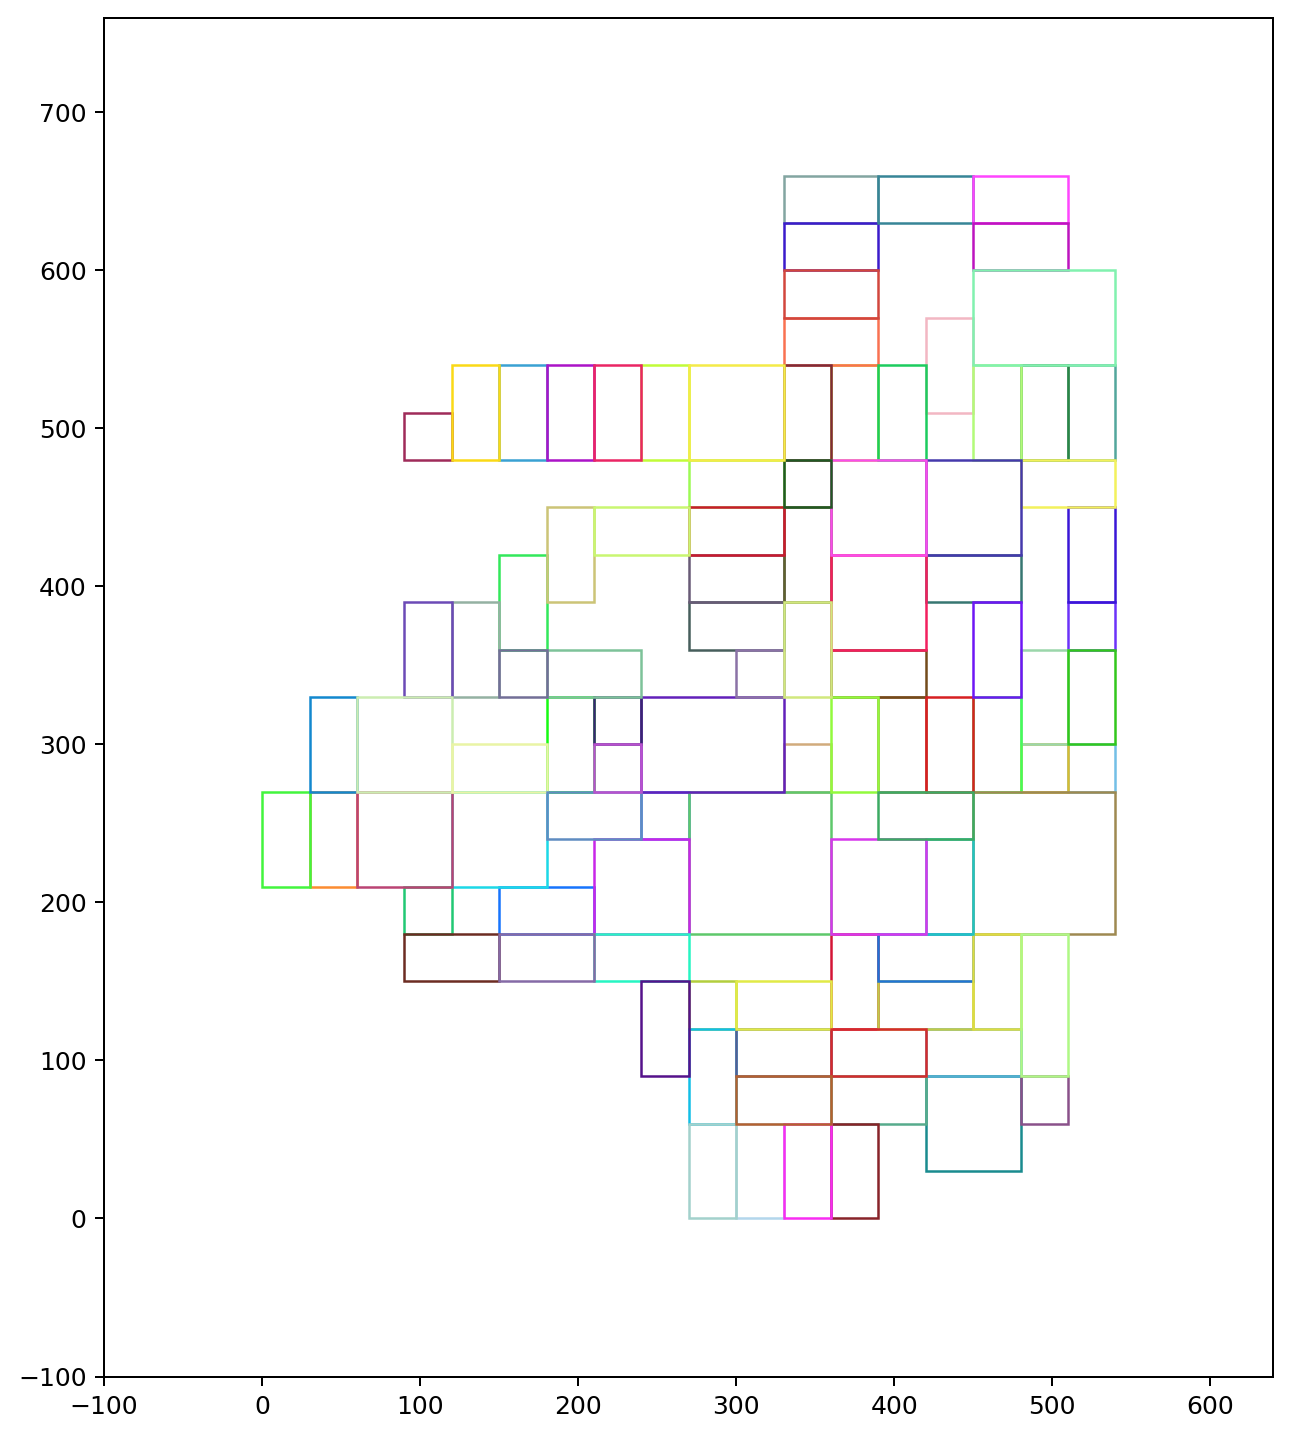

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
fig1 = plt.figure(figsize=(10,10),dpi=180)
ax1 = fig1.add_subplot(111, aspect='equal')
#ax1.add_patch(
#    patches.Rectangle(
#        (t[2][1][0]/1000, t[2][1][1]/1000),   # (x,y)
#        (t[2][1][2]-t[2][1][0])/1000,          # width
#        (t[2][1][3]-t[2][1][1])/1000,          # height
#    )
#)
for i in range(0,len(t[2])):
    random_color=randomcolor()
    ax1.add_patch(
        patches.Rectangle(
            (t[2][i][0], t[2][i][1]),   # (x,y)
            (t[2][i][2]-t[2][i][0]),          # width
            (t[2][i][3]-t[2][i][1]),          # height
            color=random_color,
            fill=False
        )
    )
    #print(t[2][i][3]-t[2][i][1])
    #print([t[2][i][0],t[2][i][1]])

xlim(-100+x_min,100+x_max)
ylim(-100+y_min,100+y_max)

#用于传递参数的模块
#if(sys.argv[1]=="on"):
#    plt.show()
#else:
#    print("ploting mode off")
fig1.savefig('rect1.png', dpi=90, bbox_inches='tight')
#print((t[2][1][2]-t[2][1][0])/10)

In [ ]:
'''def read_layout(filename):#废弃的读layout模块
    layout_info=[]
    with open(filename) as f:
          for line in f.readlines():
                    line=line.rstrip('\n')
                    layout_info.append(line.rstrip('\n'))
    #print(layout_info[0])
    instance_info=layout_info[0][1:-1]
    instance_info=instance_info.replace("\"","")
    instance_info=instance_info.split(" ")
    orient_info=layout_info[2][1:-1]
    orient_info=orient_info.replace("\"","")
    orient_info=orient_info.split(" ")
    len_instance=len(instance_info)
    len_orient=len(orient_info)
    #print(len_instance==len_orient)
    #print(instance_info[1])
    #print(orient_info[1])
    bBox_info_pre=layout_info[1]
    bBox_info_pre=bBox_info_pre.replace("(","")
    bBox_info_pre=bBox_info_pre.replace(")","")
    bBox_info_pre=bBox_info_pre.split(" ")
    #print(bBox_info_pre)
    len_bBox_pre=len(bBox_info_pre)
    #print(len_bBox_pre)
    bBox_info=[[] for i in range(int(len_bBox_pre/4))]
    for i in range(0,int(len_bBox_pre/4)):
        bBox_info[i].append(floor_to_decimal(float(bBox_info_pre[4*i+0])))
        bBox_info[i].append(floor_to_decimal(float(bBox_info_pre[4*i+1])))
        bBox_info[i].append(floor_to_decimal(float(bBox_info_pre[4*i+2])))
        bBox_info[i].append(floor_to_decimal(float(bBox_info_pre[4*i+3])))
    #print(bBox_info)
    len_bBox=len(bBox_info)
    #print(len_bBox)
    #print(len_instance)
    print("三个数据长度是否相等？：")
    print((len_instance==len_orient)&((len_instance==len_bBox)))
    #floor_to_decimal(177.2)
    return [instance_info, orient_info, bBox_info]'''